In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys

sys.path.append("/notebooks/JAXGym")

In [4]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax

import matplotlib.pyplot as plt

In [27]:
from models.base_model import BaseModel, NormalDistPredictor

from agents.REINFORCE_continuous import ActorCriticContinuous
from agents.advantage_estimator import state_value_estimator, gae_estimator

from trainer import build_trainer

from utils.callback import tqdm_callback

In [31]:
actor_lr = 2e-4
critic_lr = 2e-3

discount = 0.9

iters = 10000

max_episode_steps = 500

env_name = "Pendulum-v1"

In [32]:
env, env_params = gymnax.make(env_name)

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [36]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(cpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), NormalDistPredictor(output_size = action_size, logvar_init_value = 0.1)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.adam(actor_lr)
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])
    critic_params = critic_model.init(critic_init_key, dummy)['params']
    critic_tx = optax.adam(critic_lr)
    critic = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params,
                              tx=critic_tx,
                              )
    
    agent = ActorCriticContinuous(gae_estimator(discount, 0.95))
    
    all_rewards = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, env, env_params, obs_size, max_episode_steps, tqdm_callback(iters))
    
    carry = (actor, critic, all_rewards, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

  0%|          | 0/10000 [00:00<?, ?it/s]

(501, 1) (501, 1)


100%|██████████| 10000/10000 [01:03<00:00, 219.07it/s, Reward=-263.8534] 

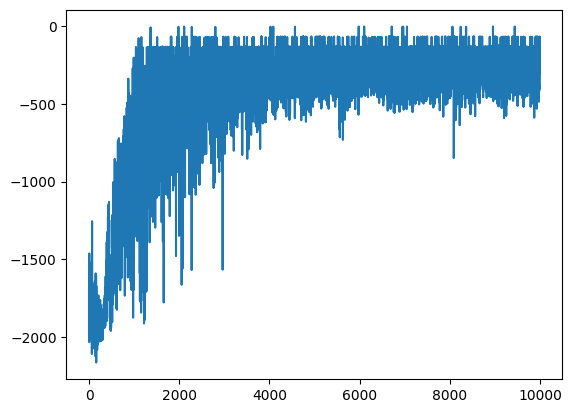

In [37]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'jaxlib.xla_extension.ArrayImpl'>
  logger.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


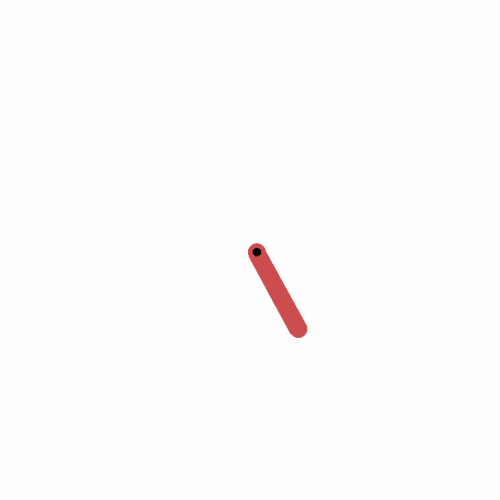

In [38]:
from utils.render import save_frames_as_gif

from IPython.display import Image
from tqdm.notebook import tqdm
import gym

actor = carry[0]

gym_env = gym.make(env_name, render_mode="rgb_array")

obs, _ = gym_env.reset()
frames = []
for t in tqdm(range(500)):
    frames.append(gym_env.render())
    action = agent.suggest_action(jnp.expand_dims(obs, 0), actor)[0]
    obs, _, done, _, _ = gym_env.step(action)
    if done:
        break
        
gym_env.close()

save_frames_as_gif(frames, filename = "tmp.gif")

Image(open('tmp.gif','rb').read())